##Image classifier using keras

The dataset consistes of cateories: tress, desert, mountains, sea, sunset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Downloading the raw data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!ls drive/MyDrive/*.zip

drive/MyDrive/miml_dataset.zip


In [10]:
!unzip -q drive/MyDrive/miml_dataset.zip
!ls

drive  miml_dataset  sample_data


In [11]:
!ls miml_dataset/

images	miml_labels_1.csv  miml_labels_2.csv


In [12]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

Resizing the data

In [13]:

df=pd.read_csv("./miml_dataset/miml_labels_1.csv")
columns=["desert", "mountains", "sea", "sunset", "trees"]
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(
      dataframe=df[:1800],
      directory="./miml_dataset/images",
      x_col="Filenames",
      y_col=columns,
      batch_size=32,
      seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=(100,100))
valid_generator=test_datagen.flow_from_dataframe(
      dataframe=df[1800:1900],
      directory="./miml_dataset/images",
      x_col="Filenames",
      y_col=columns,
      batch_size=32,
      seed=42,
      shuffle=True,
      class_mode="raw",
      target_size=(100,100))
test_generator=test_datagen.flow_from_dataframe(
      dataframe=df[1900:],
      directory="./miml_dataset/images",
      x_col="Filenames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(100,100))

Found 1800 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.


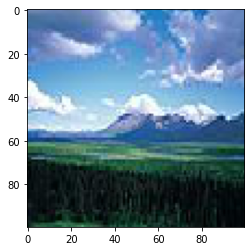

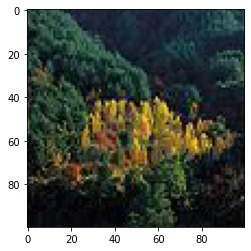

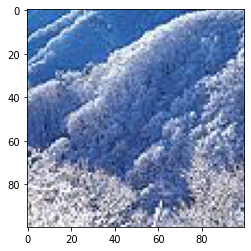

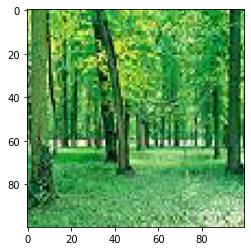

In [14]:
import matplotlib.pyplot as plt

x,y = valid_generator.next()
for i in range(0,4):
    image = x[i]
    plt.imshow(image)
    plt.show()

Training the model

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
56/56 [==============================] - 80s 1s/step - loss: 0.5612 - accuracy: 0.3121 - val_loss: 0.5905 - val_accuracy: 0.0000e+00
Epoch 2/10
56/56 [==============================] - 78s 1s/step - loss: 0.4398 - accuracy: 0.5024 - val_loss: 0.3866 - val_accuracy: 0.7396
Epoch 3/10
56/56 [==============================] - 79s 1s/step - loss: 0.4093 - accuracy: 0.5690 - val_loss: 0.4418 - val_accuracy: 0.5833
Epoch 4/10
56/56 [==============================] - 79s 1s/step - loss: 0.3781 - accuracy: 0.6002 - val_loss: 0.3283 - val_accuracy: 0.6979
Epoch 5/10
56/56 [==============================] - 79s 1s/step - loss: 0.3615 - accuracy: 0.6344 - val_loss: 0.2953 - val_accuracy: 0.6979
Epoch 6/10
56/56 [==============================] - 79s 1s/step - loss: 0.3477 - accuracy: 0.6395 - val_loss: 0.3177 - val_accuracy: 0.6875
Epoch 7/10
56/56 [==============================] - 79s 1s/step - loss: 0.3441 - accuracy: 0.6151 - val_loss: 0.3188 - val_accuracy: 0.6771
Epoch 8/10
56/56

Running on test data

reseting the test generator

In [18]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

  1/100 [..............................] - ETA: 13s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


100/100 [==============================] - 2s 20ms/step


In [19]:
pred_bool = (pred >0.5)

In [20]:
predictions = pred_bool.astype(int)
columns=["desert", "mountains", "sea", "sunset", "trees"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.head()

,Filenames,desert,mountains,sea,sunset,trees
0,1901.jpg,0,0,1,0,0
1,1902.jpg,0,0,1,0,0
2,1903.jpg,0,0,0,0,1
3,1904.jpg,0,0,1,0,0
4,1905.jpg,0,0,0,0,1
